<a href="https://colab.research.google.com/github/Hitesh111/Twitter-Sentiment-Analysis---US-Airlines/blob/master/Fine_Tuning_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 
In this notebook we will explores the Twitter US Airline Sentiment Dataset and tries to predict tweet sentiment using transfer learning and Fine tuning it, Fast.ai's library for Universal Language Model Fine-tuning for Text Classification (ULMFiT).

Introduction : ULMFiT(Universal Language Model Fine-tuning) is a tansfer learning approach for NLP(natural Language processing) tasks. This was introduced by Jeremy Howard and Sebastian Ruder in 2018. In transfer learning we use pre-tranined model for a given specific task. This helps in reducing the training time with a quite high margin.


The more about this can be found in this paper [here](https://arxiv.org/abs/1801.06146)

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


In [0]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv; pip install nltk

Loading necessary libraries 

In [0]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Fastai Librraries
from pathlib import Path
from fastai.text import *

#splitting the dataset
from sklearn.model_selection import train_test_split

# nlp word augmentation libraries
import nlpaug.augmenter.word as naw
from nlpaug.util import Action

In [0]:
path = Path('../input/twitter-airline-sentiment/')
filename = 'Tweets.csv'

## EDA 
we will start by looking into few rows of the dataset after loading it as ***tweets_df***.


Dataset has 14640 rows and 15 coulmns.

columns Names are 
        
       'tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone
       
We will drop all columns besides airline_sentiment and text, and store it in ***df***

In [0]:
filepath = path/filename
tweets_df = pd.read_csv(filepath)
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
tweets_df.shape

(14640, 15)

In [0]:
df = tweets_df[['airline_sentiment', 'text']]
df.head(6)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...


### Class Distribution of our data


In [0]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

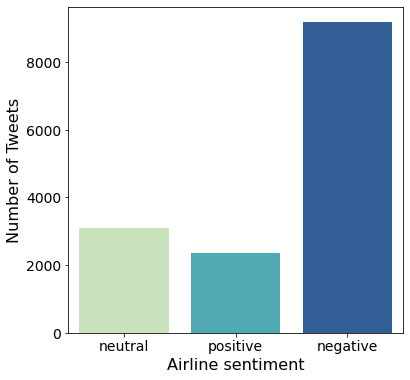

In [0]:
plt.figure(figsize=(6, 6))
sentiments_count = sns.countplot(x='airline_sentiment', data=tweets_df, palette="YlGnBu")
sns.set_style(style='darkgrid')

sentiments_count.set_xlabel("Airline sentiment",fontsize=16)
sentiments_count.set_ylabel("Number of Tweets",fontsize=16)
sentiments_count.tick_params(labelsize=14)

Here's the class distribution of our data look like:
* negative  :  9178
* neutral   :  3099
* positive  :  2363

The distribution of data quite imbalanced and is skewd towards negative sentiment,we can see that the number of Negative tweets are more than both positive and neutral combined

### Sentiment Airline-wise

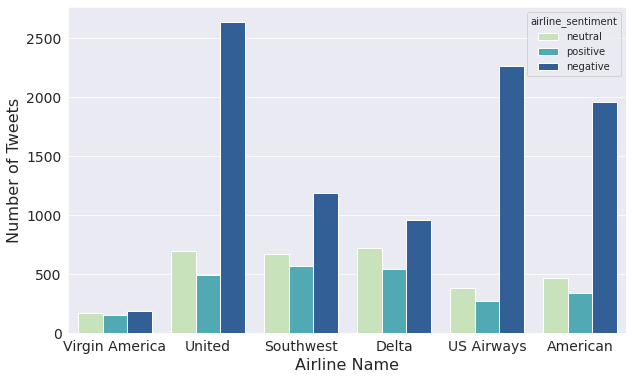

In [0]:
plt.figure(figsize=(10, 6))
airlinewise_senitment = sns.countplot(x='airline', hue='airline_sentiment', data=tweets_df,palette="YlGnBu")
sns.set_style(style='darkgrid')
airlinewise_senitment.set_ylabel("Number of Tweets",fontsize=16)
airlinewise_senitment.set_xlabel("Airline Name",fontsize=16)
airlinewise_senitment.tick_params(labelsize=14)

Here's the breakdown across the airline>
* United airline was themost popular airline in 2015 by Most number of tweets.
* Virigin america was the least popular airline in 2015 by least no tweets.
* * The most negative tweets are toward United, US Airways and American.

### Reasons for complaints

In [0]:
tweets_df['negativereason'].nunique()
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

negative_reasons_count=dict(tweets_df['negativereason'].value_counts(sort=False))
def negative_reasons_count(airline_name):
    if airline_name =='All':
        a = tweets_df
    else:
        a = tweets_df[tweets_df['airline']==airline_name]
    count = dict(a['negativereason'].value_counts())
    unique_reasons = list(tweets_df['negativereason'].unique())
    unique_reasons = [x for x in unique_reasons if str(x) != 'nan']
    reason_frame = pd.DataFrame({'Reasons':unique_reasons})
    reason_frame['count'] = reason_frame['Reasons'].apply(lambda x: count[x])
    return reason_frame
def plot_reason(airline_name):
    
    a = negative_reasons_count(airline_name)
    count = a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count )
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+airline_name)
    


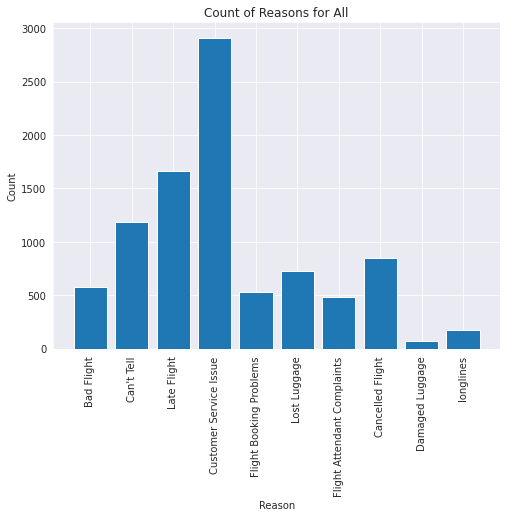

In [0]:
plt.figure(2,figsize=(8, 6))
plot_reason('All')


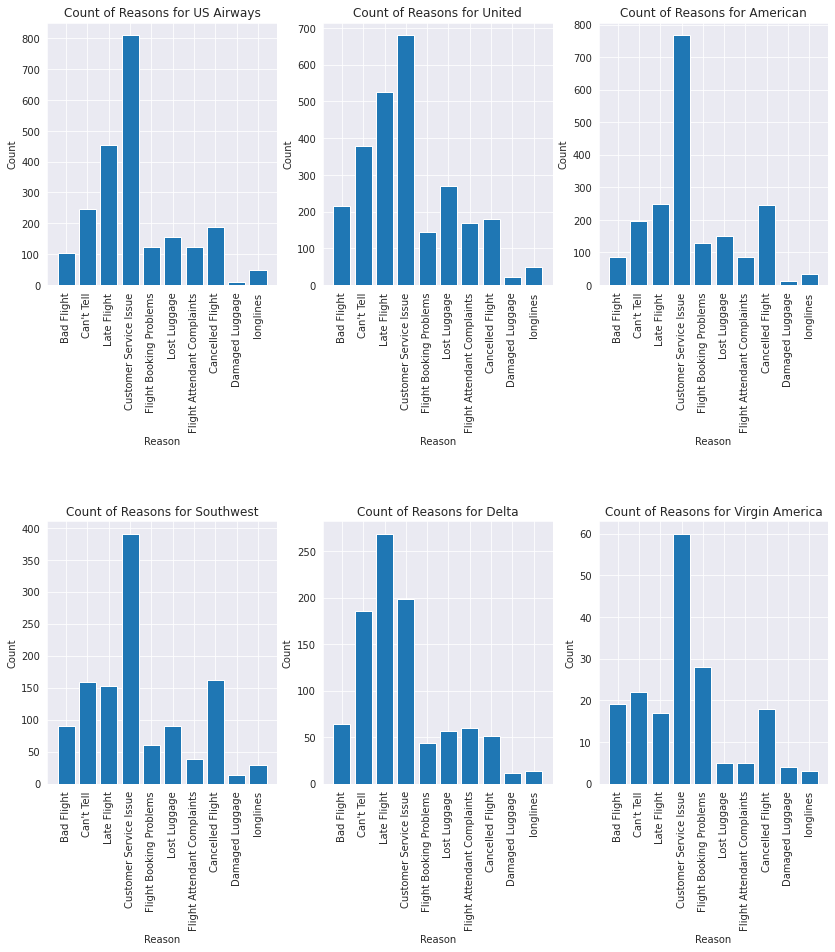

In [0]:
plt.figure(2,figsize=(14, 14))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

Top 10 reasons for negative tweets were:
1. Customer Service Issue
2. Late Flight
3. Can't tell
4. Cancelled fligts
5. Lost luggage
6. Bad Flight
7. Flight Booking Problems
8. Flight attendent complaints
9. Longliness
10. Damaged luggage


                                Top 3 Airlines - Most Late Flight Complaints¶
                                1. Delta
                                2. United
                                3. US Airways

                                Top 3 Airlines - Most Lost Luggage Complaints
                                1. United
                                2. Southwest
                                3. Delta


## Data Preprocessing
**Text substitution**                                                                                                              
Since there there is some dependence of sentiment with airlines, we will do substitute each instance of @{airline} with @airline. For example, we will replace @united with @airline. This does not remove all hints about the airlines from the text but it's still a good first step.

In [0]:
df[['airline_sentiment', 'text']].isna().sum()


airline_sentiment    0
text                 0
dtype: int64

In [0]:
import re
regex = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir)"
def text_replace(s):
    return re.sub(regex, '@airline', s, flags=re.IGNORECASE)

In [0]:
df['text'] = df['text'].apply(text_replace)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df['text'].sample(5)

6969     “@JetBlue: Our fleet's on fleek. http://t.co/L...
12790    @airline @barrettkarabis what a joke you can m...
12761                                 @airline Absolutely!
8169         @JetBlue ugh always know a way to my heart 😘🙌
4462     @airline thanks to Ella-Mae at LAS counter for...
Name: text, dtype: object

In [0]:
train, test = train_test_split(df, test_size=0.15)

**Data Augmentation**

Since we have a data imbalance problem so to deal with that we will genrate new tweet from minority class through Augmentation usig Synonym Word Replacement.
We will be using this library named **[nlpaug](https://github.com/makcedward/nlpaug)** created by  Edward Ma.

We will be splitting our data into all three classes to find how many tweets needed to generate, which will be the difference between the negative and the positive tweets and the negative and the neutral tweets respectively.

In [0]:
df_pos = train.loc[train.airline_sentiment == 'positive']
df_neu = train.loc[train.airline_sentiment == 'neutral']
df_neg = train.loc[train.airline_sentiment == 'negative']

print('There are {} positive tweets, {} neutral tweets and {} negative tweets'.format(len(df_pos), len(df_neu), len(df_neg)))

There are 1995 positive tweets, 2636 neutral tweets and 7813 negative tweets


In [0]:
# calculating number of  positive and neutral augmented tweets we have to create to balance the datasets
pos_aug = len(df_neg)-len(df_pos)
neu_aug = len(df_neg)-len(df_neu)

print('Tweets to create: {} postive tweets, {} neutral tweets'.format(pos_aug,neu_aug))

Tweets to create: 5818 postive tweets, 5177 neutral tweets


In [0]:
def train_aug(n_aug, source_df, train):
    # print and store initial df length
    train_len = len(train)
    print('Data length before augmentation: {} \n'.format(train_len))
    
    for n in range(n_aug):
        # get a random tweet from the source dataframe
        randn = random.randint(0, len(source_df)-1)
        row = source_df.iloc[randn].values
        # do synonym augmentation
        aug = naw.SynonymAug(aug_src='wordnet')
        augmented_text = aug.augment(row[1])
        # add new row to training dataframe
        new_row = {'airline_sentiment': row[0], 'text': augmented_text}
        train = train.append(new_row, ignore_index=True)
    
    new_added = len(train) - train_len
    # print 
    print('{} items added to training datafrane. Training dataframe now has {} rows'.format(new_added, len(train)))
    
    return train

In [0]:
# adding postive tweets to training data
train = train_aug(pos_aug, df_pos, train)

Data length before augmentation: 12444 

5818 items added to training datafrane. Training dataframe now has 18262 rows


In [0]:
# adding neutral tweets to training data
train = train_aug(neu_aug, df_neu, train)

Data length before augmentation: 18262 

5177 items added to training datafrane. Training dataframe now has 23439 rows


In [0]:
len_df_all = len(train) + len(test)
print('Train length: {}, Test length: {}, Combined data length {}'.format(len(train), len(test), len_df_all))

Train length: 23439, Test length: 2196, Combined data length 25635


> ***In FastAi V3 course on deeplearning jeremy howard had suggested using all of data for improving the language model, so we will be concatenating the two.***

In [0]:
# concat train and test set for language model
df_lm = pd.concat([train, test])
print(len(df_lm))

25635


In [0]:
df_lm.sample(5)

,airline_sentiment,text
5259,negative,@airline No flights out of Philly because of s...
19675,neutral,@ airway our escape attendant foretell that we...
13349,positive,Ne'er got to the strip that fast before . Stok...
17693,positive,@ airline Please Help . We in truth need to fl...
23115,neutral,@ airline also checked e mail you have on file...


In [0]:
moms = (0.8,0.7)
wd = 0.1

## Get Pre-Trained model

In [0]:
working_path = Path('./').resolve() # fastai needs a working path

In [0]:
# prepare/pre-process langauge model data
data_lm = (TextList.from_df(df_lm, cols='text')
                   .split_by_rand_pct(0.05, seed=42) # default for valid_pct=0.2, we're using 0.05, so we have more data to train lm
                   .label_for_lm() # the text is the label
                   .databunch())

In [0]:
data_lm.show_batch()

idx,text
0,has to send me to someone else . xxbos @airline xxmaj this was a real life exercise in crisis management which @airline failed xxunk . xxmaj some compensation would go a long way . xxbos @jetblue xxmaj why would you charge money to transfer points to someone ? xxbos @jetblue your customer service agent xxmaj bonnie is amazing on the phone she deserves a promotion ! ! ! xxbos @airline
1,"that your great people got me home safely . xxmaj sad for others who did n't get back bc of scheduling problems . xxbos @jetblue xxmaj indeed . i do n't know what 's going on in xxmaj pittsburgh that weekend , but , it 's drawing a crowd via jetblue ! xxbos @airline go south everyone xxbos @airline i promise , if i can help it i will nvr"
2,after planned . xxrep 4 😡 😤 😤 😤 xxbos @jetblue xxmaj social xxmaj media xxmaj takes xxmaj flight with xxmaj fly # xxunk - xxmaj what brand lesson can we learn ? # xxup xxunk # xxmaj brand https : / / t.co / xxunk xxbos @airline xxmaj thanks . xxbos @airline i keep getting hung up on . xxup please respond so i can book a ticket with
3,bf will make good use of the voucher # satisfied # happycustomer xxbos @jetblue u xxunk have been sitting here for xxunk because of ur negligence xxbos @jetblue do you have any afternoon flights going from xxup bqn to xxup jfk ? i only seem to find early morning flights . xxbos @airline ... just called and lady at your overseas call center said she saw no note . i
4,- xxunk ? xxmaj really ? xxmaj after i was told by midnight multiple times ? xxmaj why lie ? xxmaj crazy and bad business . xxbos @airline xxunk that can be a stop over before xxmaj paris . xxmaj you are an xxunk xxbos @airline i am blown away by stellar # custserv ! ! xxmaj thank you <3 http : / / t.co / jorescfb4x xxbos @airline schedule


In [0]:
# save data
data_lm.save('data_lm.pkl')

In [0]:
# this fetches the wiki103 model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, error_rate]) 
learn.freeze()

## Fine-tuning the language model


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 6.31E-02


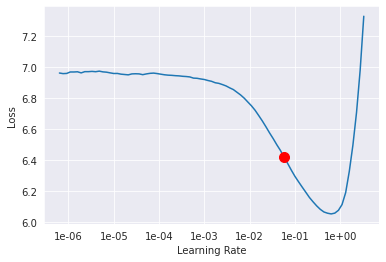

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# 5.0E-02 is LR with the steepest slope above
learn.fit_one_cycle(1, 5.0E-02, moms=moms, wd=wd) 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.048082,3.683104,0.311543,0.688457,00:17


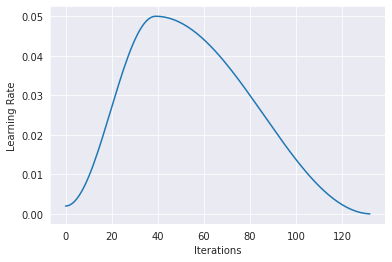

In [0]:
# This show the behaviour of our learning rate during training
learn.recorder.plot_lr()

In [0]:
# unfreeze model
learn.unfreeze()

In [0]:
learn.fit_one_cycle(3, 5.0E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.352924,3.383554,0.348788,0.651212,00:18
1,2.940231,3.074240,0.405198,0.594802,00:18
2,2.372222,3.009771,0.424841,0.575159,00:18


In [0]:
learn.predict('are you sure, will ', n_words=20)

"are you sure, will  refund my ticket when ill be flying AA ? i know the worst big reasons i 've travels tonight"

In [0]:
learn.save('fine_tuned')

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier Fine tuning

In [0]:
train_valid, test = train_test_split(df, test_size=0.2) # train_valid and test set
train, valid = train_test_split(train_valid, test_size=0.2) # train and valid data that goes into clasifer 

In [0]:
# loading the data classifier model using the language model vocabulary
data_clas = TextClasDataBunch.from_df(working_path, train, valid, 
                                      test_df=test, 
                                      vocab=data_lm.train_ds.vocab, 
                                      text_cols='text', 
                                      label_cols='airline_sentiment', bs=32)

In [0]:
data_clas.save('data_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
xxbos @airline i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @airline xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj honorable ! xxmaj we xxup will xxup be xxmaj an xxmaj economic xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @airline e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @airline xxmaj why do i still not have my bags ? xxmaj they arrived xxup xxunk & & website says they 're still at the airport .. 2 1 / 2 hours xxmaj late xxmaj flightr ? ? ? ! ! # nothappy,negative
xxbos @airline xxmaj hi ! xxmaj just got my xxup tsa pre - check # & & put it in my acct . xxmaj but it 's not on my boarding pass for a flight this xxunk . xxmaj can it be updated ?,negative


In [0]:
#initalize model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, error_rate])
learn.load_encoder('fine_tuned_enc') #loading the language model encoder into the classifer
learn.freeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.74E-02


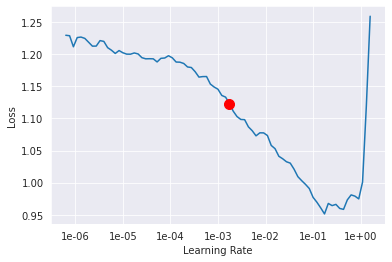

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

**Gradual freezing**

Here we will be train the model by gardually unfreezing the layers, layer by laer.
We will start from last layer and we also decrease the learning rate as we train deeper layers in the model.
Since the earlier layers have more gerneralized knowledge hence need less training.
This method was also propsed by the Ruder and Howard.

In [0]:
# training last layer
lr = 3.0E-02
learn.fit_one_cycle(1, lr, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.609129,0.511075,0.790866,0.209134,00:10


In [0]:
learn.save('first')
# learn.load('first)

In [0]:
# train last two layers
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.569399,0.456437,0.836108,0.163892,00:10


In [0]:
learn.save('second')
# learn.load('first)

In [0]:
# training last three layers
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.493650,0.433958,0.837815,0.162185,00:11


In [0]:
# training all the layers
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.432074,0.430888,0.827145,0.172855,00:11
1,0.362202,0.436246,0.834400,0.165600,00:11
2,0.326232,0.438690,0.834400,0.165600,00:11


In [0]:
learn.predict('should i be flying')

(Category neutral, tensor(1), tensor([0.1591, 0.7335, 0.1074]))

In [0]:
learn.predict('flight delayed, again')

(Category negative, tensor(0), tensor([0.9846, 0.0115, 0.0039]))

In [0]:
learn.predict("Safe flight!")

(Category positive, tensor(2), tensor([0.0070, 0.0199, 0.9731]))

# summary of results

## Accuracy of the Model

In [0]:
interpretation = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interpretation.preds, interpretation.y_true)
err = error_rate(interpretation.preds, interpretation.y_true)
print('Accuracy: {0:.3f}'.format(acc))
print('Error rate: {0:.3f}'.format(err))

Accuracy: 0.834
Error rate: 0.166


## Confusion Matrix

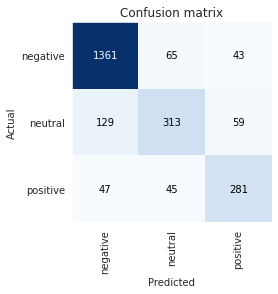

In [0]:
interpretation.plot_confusion_matrix()

In [0]:
interpretation.most_confused()

[('neutral', 'negative', 129),
 ('negative', 'neutral', 65),
 ('neutral', 'positive', 59),
 ('positive', 'negative', 47),
 ('positive', 'neutral', 45),
 ('negative', 'positive', 43)]

In [0]:
interpretation.show_top_losses(20)

Text,Prediction,Actual,Loss,Probability
"xxbos @airline oh , ok ! all good ! looking forward to xxunk the cold for a bit ! thanks !",positive,negative,6.68,0.00
"xxbos @jetblue what are the chances of actually flying out of xxmaj charleston today ? ? xxmaj cold , rainy weather in the south of all places ...",neutral,positive,6.51,0.00
xxbos @airline want to pick up a customer from @spiritairlines sign me up 🙌 😏,positive,negative,5.99,0.00
xxbos @airline come back to # xxup phl already . xxmaj we need you to take us out of this horrible cold . # xxunk http : / / t.co / xxunk,negative,positive,5.61,0.00
xxbos @jetblue finally ! xxmaj finally !,positive,neutral,5.16,0.01
xxbos @jetblue saved the day : ) @expedia lost a costumer # jetblue # xxunk # xxunk,negative,positive,5.15,0.01
xxbos @jetblue you just tight that you 're # 59 on the world 's best airlines list & & @virginatlantic is ranked higher ! @virginatlantic here i come !,positive,neutral,5.14,0.01
xxbos @airline i have two tight connections in # xxmaj charlotte and # xxmaj frankfurt,neutral,negative,5.07,0.01
"xxbos @airline yep , check it and my gmail ' xxmaj promotions ' folder xxunk ... :-(",neutral,negative,5.00,0.01
xxbos @airline i 'll try to have a great week once i receive it 😩 😭 💔,positive,negative,5.00,0.01


As we can from the results that our model seems to be confusing neutral tweets with negative tweets.                   
For Negative tweets the prediction accuracy is pretty high as we can see the true negatives.                           
For Positive Tweets its doing a pretty good job.                                                                       

If we see the those misclassifed tweets we can that many tweets are misslabeled, which in result increasing our classification error.

